# LSTM
- Energy Consumption
- https://www.kaggle.com/robikscube/hourly-energy-consumption
- DAYTON_hourly.csv

# Data processing

## Load data

In [1]:
import numpy as np
import pandas as pd
df_all = pd.read_csv('DAYTON_hourly.csv')
#df_all = pd.read_csv('https://github.com/nnnpooh/energy-class/blob/main/T2%20-%20ARIMA/DAYTON_hourly.csv?raw=true')
df_all.head()

,Datetime,DAYTON_MW
0,2004-12-31 01:00:00,1596.0
1,2004-12-31 02:00:00,1517.0
2,2004-12-31 03:00:00,1486.0
3,2004-12-31 04:00:00,1469.0
4,2004-12-31 05:00:00,1472.0


## Filtering

In [2]:
df_all['Datetime'] = pd.to_datetime(df_all['Datetime'])
df = df_all.set_index('Datetime')
df.head()

,DAYTON_MW
Datetime,
2004-12-31 01:00:00,1596.0
2004-12-31 02:00:00,1517.0
2004-12-31 03:00:00,1486.0
2004-12-31 04:00:00,1469.0
2004-12-31 05:00:00,1472.0


## Resampling
- Note that for day resampling (D), there is missing data.

In [3]:
max_sample = 365
#df_avg = df['DAYTON_MW'].resample('MS').mean()
df_avg = df['DAYTON_MW'].resample('D').mean()
if max_sample > 0:
    df_avg = df_avg.iloc[-max_sample-1:-1]
display(df_avg.describe())

#Convert result to DataFrame
df_avg = pd.DataFrame(df_avg)
df_avg.columns = ['y']

count     365.000000
mean     2027.813333
std       260.979131
min      1407.166667
25%      1835.416667
50%      2008.708333
75%      2199.791667
max      2796.583333
Name: DAYTON_MW, dtype: float64

In [4]:
# Check for missing value
df_avg.info()
#df_avg[df_avg.isna().any(axis=1)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2017-08-03 to 2018-08-02
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


## Replace missing values
- Using rolling average

In [5]:
n_rows = df_avg[df_avg.isna().any(axis=1)].shape[0]
print(f"Number NaN rows are {n_rows}.")
if n_rows > 0:
    print(f"Replace missing values with rolling average.")
    df_rolling = df_avg['y'].rolling(24,min_periods=1,).mean()
    df_avg['y'] = df_avg['y'].fillna(df_rolling)

Number NaN rows are 0.


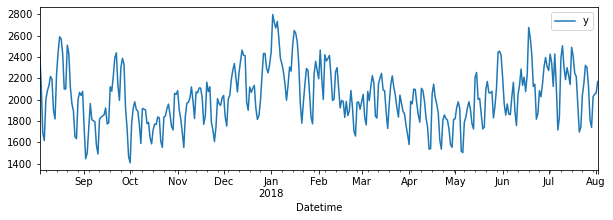

In [6]:
import matplotlib.pyplot as plt
df_avg.plot(figsize=(10, 3))
plt.show()

## Scaling data

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_avg['y (scaled)'] = scaler.fit_transform(df_avg[['y']])
display(df_avg.head())

,y,y (scaled)
Datetime,,
2017-08-03,2433.041667,0.738349
2017-08-04,2129.250000,0.519703
2017-08-05,1684.875000,0.199874
2017-08-06,1614.625000,0.149313
2017-08-07,1995.333333,0.423319


## Converting time series into supervised data

In [8]:
window_size = 10

In [9]:
dft = df_avg.copy()
dft['split'] = ''
for i in range(1, window_size + 1):
    col = f"t-{i}" 
    dft[col] = dft.iloc[:,1].shift(i)
display(dft.head())
display(dft.tail())

,y,y (scaled),split,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,,,
2017-08-03,2433.041667,0.738349,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-04,2129.250000,0.519703,,0.738349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-05,1684.875000,0.199874,,0.519703,0.738349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-06,1614.625000,0.149313,,0.199874,0.519703,0.738349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-07,1995.333333,0.423319,,0.149313,0.199874,0.519703,0.738349,NaN,NaN,NaN,NaN,NaN,NaN


,y,y (scaled),split,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,,,
2018-07-29,1738.791667,0.238679,,0.289990,0.517753,0.642836,0.657830,0.536826,0.454897,0.241768,0.207131,0.398339,0.581689
2018-07-30,2026.333333,0.445631,,0.238679,0.289990,0.517753,0.642836,0.657830,0.536826,0.454897,0.241768,0.207131,0.398339
2018-07-31,2051.083333,0.463444,,0.445631,0.238679,0.289990,0.517753,0.642836,0.657830,0.536826,0.454897,0.241768,0.207131
2018-08-01,2060.291667,0.470071,,0.463444,0.445631,0.238679,0.289990,0.517753,0.642836,0.657830,0.536826,0.454897,0.241768
2018-08-02,2168.208333,0.547742,,0.470071,0.463444,0.445631,0.238679,0.289990,0.517753,0.642836,0.657830,0.536826,0.454897


In [10]:
dft = dft.dropna()

## Split data into training and testing set

In [11]:
test_size = 0.2
n_rows = dft.shape[0]
train_size = int(n_rows * (1-test_size))
test_size = n_rows - train_size
dft.iloc[0:train_size, 2] = 'train'
dft.iloc[train_size:, 2] = 'test'

In [12]:
dft.head()

,y,y (scaled),split,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
Datetime,,,,,,,,,,,,,
2017-08-13,1817.916667,0.295628,train,0.353806,0.563426,0.582259,0.519013,0.485396,0.423319,0.149313,0.199874,0.519703,0.738349
2017-08-14,2236.500000,0.596893,train,0.295628,0.353806,0.563426,0.582259,0.519013,0.485396,0.423319,0.149313,0.199874,0.519703
2017-08-15,2442.791667,0.745367,train,0.596893,0.295628,0.353806,0.563426,0.582259,0.519013,0.485396,0.423319,0.149313,0.199874
2017-08-16,2588.583333,0.850297,train,0.745367,0.596893,0.295628,0.353806,0.563426,0.582259,0.519013,0.485396,0.423319,0.149313
2017-08-17,2569.083333,0.836262,train,0.850297,0.745367,0.596893,0.295628,0.353806,0.563426,0.582259,0.519013,0.485396,0.423319


In [13]:
filt = dft['split'] == 'train'
X_train = dft[filt].iloc[:,3:].values
y_train = dft[filt].iloc[:,1].values
#
filt = dft['split'] == 'test'
X_test = dft[filt].iloc[:,3:].values
y_test = dft[filt].iloc[:,1].values
#
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(284, 10)
(71, 10)
(284,)
(71,)


## Reshape input data for LSTM traning
- Dimension: \[samples, time steps, features\]


In [14]:
X_train_rs = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rs = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#
print(X_train_rs.shape)
print(X_test_rs.shape)

(284, 1, 10)
(71, 1, 10)


# Training model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Model building

In [16]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_rs.shape[1], X_train_rs.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

## Training

In [17]:
history = model.fit(X_train_rs, y_train, epochs=100, batch_size=10, validation_data=(X_test_rs, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1, shuffle=False)

model.summary()

Epoch 1/100
29/29 [==============================] - 1s 18ms/step - loss: 0.0659 - val_loss: 0.0394
Epoch 2/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0285 - val_loss: 0.0299
Epoch 3/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0252 - val_loss: 0.0268
Epoch 4/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0229 - val_loss: 0.0255
Epoch 5/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0216 - val_loss: 0.0242
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0202 - val_loss: 0.0228
Epoch 7/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0191 - val_loss: 0.0216
Epoch 8/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0207
Epoch 9/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0167 - val_loss: 0.0199
Epoch 10/100
29/29 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0194
Epoch 11

## Predictions

In [18]:
# Creating new DataFrame to store results
dft_result = dft.iloc[:,0:3]

# Model predictions
y_pred_train = model.predict(X_train_rs)
y_pred_test = model.predict(X_test_rs)
y_pred = np.concatenate((y_pred_train, y_pred_test), axis=0)

# Invert predictions
y_pred_train_pl = scaler.inverse_transform(y_pred_train)
y_pred_test_pl = scaler.inverse_transform(y_pred_test)
y_pred_pl = scaler.inverse_transform(y_pred)

# Storing results
dft_result['y_pred (scaled)'] = y_pred 
dft_result['y_pred'] = y_pred_pl

In [19]:
dft_result.head()

,y,y (scaled),split,y_pred (scaled),y_pred
Datetime,,,,,
2017-08-13,1817.916667,0.295628,train,0.299967,1823.946045
2017-08-14,2236.500000,0.596893,train,0.431543,2006.759277
2017-08-15,2442.791667,0.745367,train,0.608182,2252.184814
2017-08-16,2588.583333,0.850297,train,0.672773,2341.928467
2017-08-17,2569.083333,0.836262,train,0.789065,2503.506348


## Evaluation

In [20]:
def model_eval(df_eval):
    MAE = dft_eval['error'].abs().mean()
    RMSE = np.sqrt((dft_eval['error']**2).mean())
    MAPE = dft_eval['percentage'].abs().mean()
    print(f"-------")
    print(f"Mean absolute error: {MAE:6.3f}")
    print(f"Root mean squared error: {RMSE:6.3f}")
    print(f"Mean absolute percentage error: {MAPE:6.3f}")

In [21]:
dft_result['error'] = dft_result['y'] - dft_result['y_pred']
dft_result['percentage'] = dft_result['error']/dft_result['y']*100

dft_eval = dft_result[dft_result['split'] == 'train']
print(f"Training")
model_eval(dft_eval)

print(f"\nTesting")
dft_eval = dft_result[dft_result['split'] == 'test']
model_eval(dft_eval)

print(f"\nAll")
model_eval(dft_result)

Training
-------
Mean absolute error: 102.578
Root mean squared error: 131.311
Mean absolute percentage error:  5.062

Testing
-------
Mean absolute error: 139.398
Root mean squared error: 171.680
Mean absolute percentage error:  6.438

All
-------
Mean absolute error: 139.398
Root mean squared error: 171.680
Mean absolute percentage error:  6.438


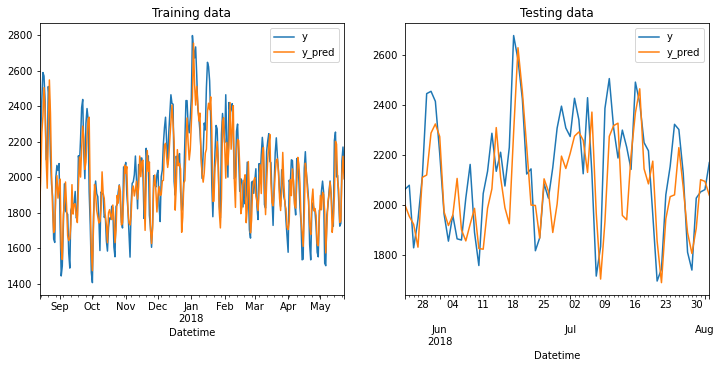

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

dft_plot = dft_result[dft_result['split'] == 'train']
dft_plot[['y', 'y_pred']].plot(ax=ax1)
ax1.set_title('Training data')

dft_plot = dft_result[dft_result['split'] == 'test']
dft_plot[['y', 'y_pred']].plot(ax=ax2)
ax2.set_title('Testing data')

plt.show()

# Forecasting

## Retrain the model with entire data

In [23]:
# Extract data
X_train = dft.iloc[:,3:].values
y_train = dft.iloc[:,1].values

# Reshape data
X_train_rs = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

print(X_train_rs.shape)
print(y_train.shape)

(355, 1, 10)
(355,)


In [24]:
history = model.fit(X_train_rs, y_train, epochs=100, batch_size=10, validation_data=(X_test_rs, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1, shuffle=False)

model.summary()

Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0107 - val_loss: 0.0137
Epoch 2/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0134
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0134
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0101 - val_loss: 0.0133
Epoch 5/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0106 - val_loss: 0.0133
Epoch 6/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0131
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0105 - val_loss: 0.0131
Epoch 8/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0131
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0130
Epoch 10/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0130
Epoch 11/

## Storing prediction result

In [25]:
y_pred = model.predict(X_train_rs)
y_pred_pl = scaler.inverse_transform(y_pred)
dft_result['y_pred_2 (scale)'] = y_pred
dft_result['y_pred_2'] = y_pred_pl
display(dft_result.head())

,y,y (scaled),split,y_pred (scaled),y_pred,error,percentage,y_pred_2 (scale),y_pred_2
Datetime,,,,,,,,,
2017-08-13,1817.916667,0.295628,train,0.299967,1823.946045,-6.029378,-0.331664,0.311325,1839.726807
2017-08-14,2236.500000,0.596893,train,0.431543,2006.759277,229.740723,10.272333,0.477882,2071.143311
2017-08-15,2442.791667,0.745367,train,0.608182,2252.184814,190.606852,7.802829,0.645387,2303.878418
2017-08-16,2588.583333,0.850297,train,0.672773,2341.928467,246.654867,9.528566,0.702194,2382.807373
2017-08-17,2569.083333,0.836262,train,0.789065,2503.506348,65.576986,2.552544,0.820976,2547.844482


## Forecasting

In [26]:
n_forecast = 10

In [27]:
y = dft_result['y (scaled)'].values
freq = dft_result.index.freq
dt_last = dft_result.index[-1]
dts = []
for i in range(1,n_forecast+1):
    x = y[-window_size-1:-1]
    x = x.reshape(1,1,-1)
    y = np.append(y,model.predict(x).flatten())
    dts.append(dt_last + freq * i)

y_fore = y[-n_forecast-1:-1]
y_fore_pl = scaler.inverse_transform([y_fore]).ravel()

dft_forecast = pd.DataFrame( {'date_time': dts, 'y_fore (scaled)': y_fore, 'y_fore': y_fore_pl} )
dft_forecast = dft_forecast.set_index('date_time')
dft_forecast.head()

,y_fore (scaled),y_fore
date_time,,
2018-08-03,0.547742,2168.208333
2018-08-04,0.330833,1866.831907
2018-08-05,0.482456,2077.498782
2018-08-06,0.627437,2278.937754
2018-08-07,0.571594,2201.349559


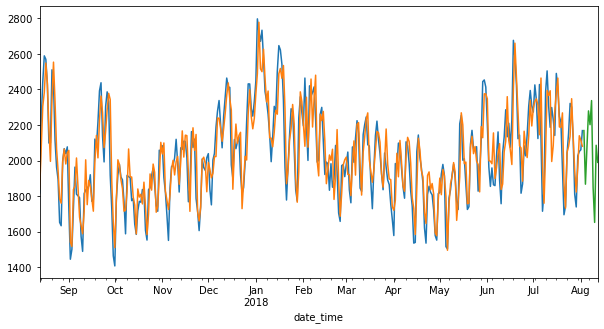

In [28]:
fig, ax = plt.subplots(figsize=(10,5))
dft_result['y'].plot(ax=ax)
dft_result['y_pred_2'].plot(ax=ax)
dft_forecast['y_fore'].plot(ax=ax)
plt.show()

(17596.0, 17755.0)

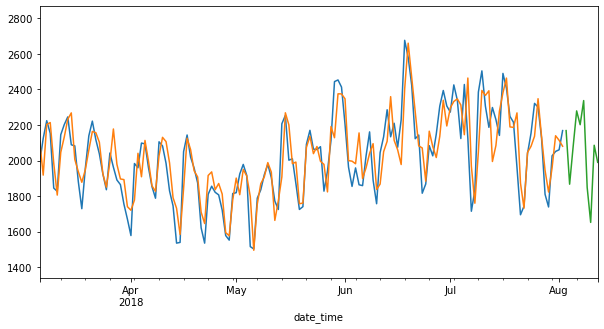

In [29]:
fig, ax = plt.subplots(figsize=(10,5))
dft_result['y'].plot(ax=ax)
dft_result['y_pred_2'].plot(ax=ax)
dft_forecast['y_fore'].plot(ax=ax)

dt_start = dft_result.index[-n_forecast*15]
dt_end = dft_forecast.index[-1]
ax.set_xlim(dt_start,dt_end)